# AI Skill Showcase - Joshua Barre

Hi, my name is Josh and I am in 1A Honours Math here at UWaterloo. I have been indulges in coding and especially AI since a very young age of 13 and have always loved it growing up. I reveived my AI Azure from Microsoft when I was 14 and have been building AI projects ever since. When I discovered Wat.ai as a club here at Waterloo I was ecstatic and believe that this is a place where I can not only contribute to a greater project but also learn from the experience and grow in my knowledge of AI and ML. SEE-DR project specifically really meant alot as my brother was just recently diagnosed with Type 1 Diabetes. The way we figured out was actually through his blurry vision which is what this project is all about. Seeing the life of my brother change overnight having to keep track of all his calories and triple check everything he does really showed me the potential of what AI can really do for him. This project is the place I believe I can grow and make a meaningful impact on the world.

### This project implements neural style transfer. It takes any image in and basically puts a filter on it with the artistic style of Van Goh. It uses a pretrained VGG-19 neural network (originally trained on ImageNet). It optimizes each image to have better results, but this also causes it to take much longer.

Import all requirements

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


Load the images

In [ ]:
def load_image(path, size=512):
    image = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# I used a for loop so that one can put any number of images and optimze them all at once.

content_images = [load_image(f'images/content{i}.jpg').to(device) for i in range(1,3)]
style_image    = load_image('images/style.jpg').to(device)


Pretrained VGG Feature Extractor

In [4]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze parameters
for param in vgg.parameters():
    param.requires_grad = False


/Users/joshbarre/ai-skill-showcase/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/joshbarre/ai-skill-showcase/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/joshbarre/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100.0%


Layers for content and style of the images

In [5]:
# Content layer
content_layers = ['21']

# Style layers
style_layers = ['0','5','10','19','28'] 


Define a function to compute Gram matrices

In [6]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h*w)
    G = torch.mm(features, features.t())
    return G


Get the features from an original Van Goh painting

In [7]:
def get_features(x, model, layers):
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features


Optimization Loop. Not actually training but optimizing each image and measuring loss.

In [8]:

output_images = [content.clone().requires_grad_(True) for content in content_images]

optimizer = optim.Adam(output_images, lr=0.01)
epochs = 300

# each epoch makes the image look better and more like Van Goh painting

for epoch in range(epochs):
    total_loss = 0

    for i, content in enumerate(content_images):
        optimizer.zero_grad()

        content_features = get_features(content, vgg, content_layers)
        style_features   = get_features(style_image, vgg, style_layers)
        output_features  = get_features(output_images[i], vgg, content_layers + style_layers)

        # Content loss
        content_loss = nn.MSELoss()(output_features['21'], content_features['21'])

        # Style loss
        style_loss = 0
        for layer in style_layers:
            G = gram_matrix(output_features[layer])
            G_s = gram_matrix(style_features[layer])
            style_loss += nn.MSELoss()(G, G_s)
        
        # Total loss (weight content vs style)
        loss = content_loss*1 + style_loss*1e6
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(content_images):.4f}')


Epoch 50/300, Loss: 4660846788608.0000
Epoch 100/300, Loss: 2925772242944.0000
Epoch 150/300, Loss: 2108106293248.0000
Epoch 200/300, Loss: 1577413410816.0000
Epoch 250/300, Loss: 1229789265920.0000
Epoch 300/300, Loss: 998312206336.0000


Display the original content images next to their final Van Gogh-styled versions for comparison.

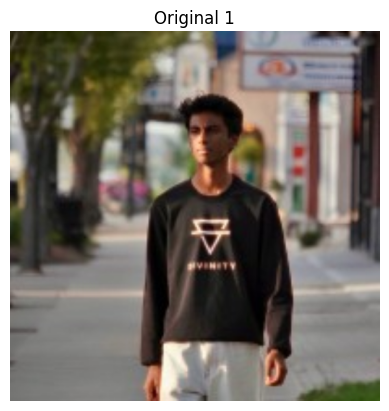

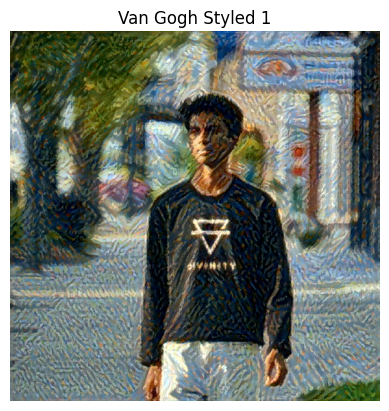

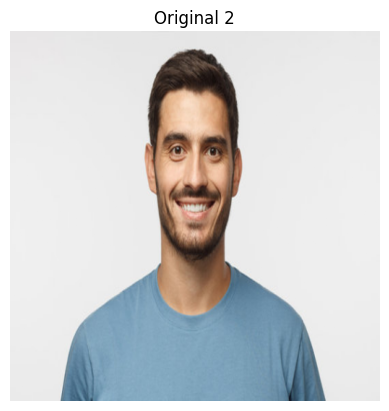

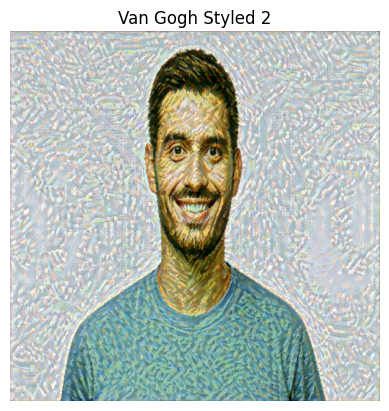

In [9]:
def show_image(tensor, title=''):
    img = tensor.cpu().detach().squeeze(0).permute(1,2,0)
    img = img.clamp(0,1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

for i, content in enumerate(content_images):
    show_image(content, f'Original {i+1}')
    show_image(output_images[i], f'Van Gogh Styled {i+1}')
